# **Capstone Project – The Battle of Neighborhoods for finding a better place in Scarborough, Toronto**

Importing Libraries and installing some packages

In [1]:
!pip install geocoder
!pip install folium
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

     |████████████████████████████████| 102kB 4.2MB/s 
All Required Libraries Imported!


###**Data Extraction and Preprocessing**

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 

Link- https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M



In [14]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

#Converting content of PostalCode HTML table as dataframe
table_contents=[]
table=wiki_data.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})  

df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M5B,North York,Humber Summit
freq,1,24,1


In [17]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.PostalCode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [19]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')
df_2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M5B,North York,Humber Summit
freq,1,24,1


In [21]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
# get_latilong('M4G')
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [23]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']
df_2[df_2.PostalCode == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [24]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


### **Map of Scarborough, Toronto**

In [25]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [37]:
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [38]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [39]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [40]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### **NearBy Venues**

In [41]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
2,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775512,-79.258288
3,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069
4,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


### **Categories of nearby venues**

In [42]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,American Eagle Store,Clothing Store,43.776012,-79.258334
2,SEPHORA,Cosmetics Shop,43.775512,-79.258288
3,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069
4,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


In [43]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store         9
Restaurant             5
Coffee Shop            4
Pharmacy               2
Intersection           2
Sandwich Place         2
Department Store       2
Gas Station            2
Wings Joint            1
Sporting Goods Shop    1
Name: categories, dtype: int64

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [46]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 303 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,24,24,24,24,24,24
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",13,13,13,13,13,13
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27


### **One hot encoding**

In [47]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride /

In [48]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                  venue  freq
0    Chinese Restaurant  0.08
1         Shopping Mall  0.08
2  Hong Kong Restaurant  0.04
3        Sandwich Place  0.04
4      Department Store  0.04


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store  0.12
1                Gym  0.12
2        Pizza Place  0.12
3        Coffee Shop  0.12
4           Pharmacy  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Coffee Shop  0.15
1          Mobile Phone Shop  0.08
2                Pizza Place  0.08
3  Middle Eastern Restaurant  0.08
4        Fried Chicken Joint  0.08


---- Bayview Village ----
              venue  freq
0  Asian Restaurant  0.17
1       Flower Shop  0.17
2              Park  0.17
3             Trail  0.17
4           Dog Run  0.17


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0          Restaurant  0.07
1         Coffee Shop  0.07
2      Sandwich Pla

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### **Most common venues near neighborhoods**

In [50]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Sandwich Place,Sushi Restaurant,Supermarket,Latin American Restaurant,Breakfast Spot,Bubble Tea Shop,Skating Rink,Pool
1,"Alderwood, Long Branch",Convenience Store,Pizza Place,Sandwich Place,Gym,Gas Station,Pharmacy,Coffee Shop,Pub,Farm,Falafel Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Deli / Bodega,Middle Eastern Restaurant,Sandwich Place,Sushi Restaurant,Park,Grocery Store,Restaurant,Fried Chicken Joint,Pizza Place
3,Bayview Village,Flower Shop,Dog Run,Park,Gas Station,Trail,Asian Restaurant,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Restaurant,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Pizza Place,Liquor Store,Juice Bar,Sports Club,Thai Restaurant


## **K-Means Clustering Implementation**

In [51]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2], dtype=int32)

In [52]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Scarborough_merged =df_2.iloc[:16,:]
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Scarborough_merged.head()# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,0,Home Service,Paintball Field,Construction & Landscaping,Fast Food Restaurant,Financial or Legal Service,Zoo Exhibit,Vietnamese Restaurant,Doner Restaurant,Dry Cleaner,Dumpling Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,0,Home Service,Fish & Chips Shop,Bar,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,1,Park,Gym / Fitness Center,Athletics & Sports,Gymnastics Gym,Field,Escape Room,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,M1G,Scarborough,Woburn,43.76812,-79.21761,1,Coffee Shop,Park,Chinese Restaurant,Fast Food Restaurant,Event Space,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,0,Bakery,Hakka Restaurant,Caribbean Restaurant,Gas Station,Athletics & Sports,Bank,Lounge,Playground,Thai Restaurant,Farmers Market


**Map of Clusters**

In [53]:
# create map
kclusters=10
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [55]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [57]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                                                          
                                                              ]})

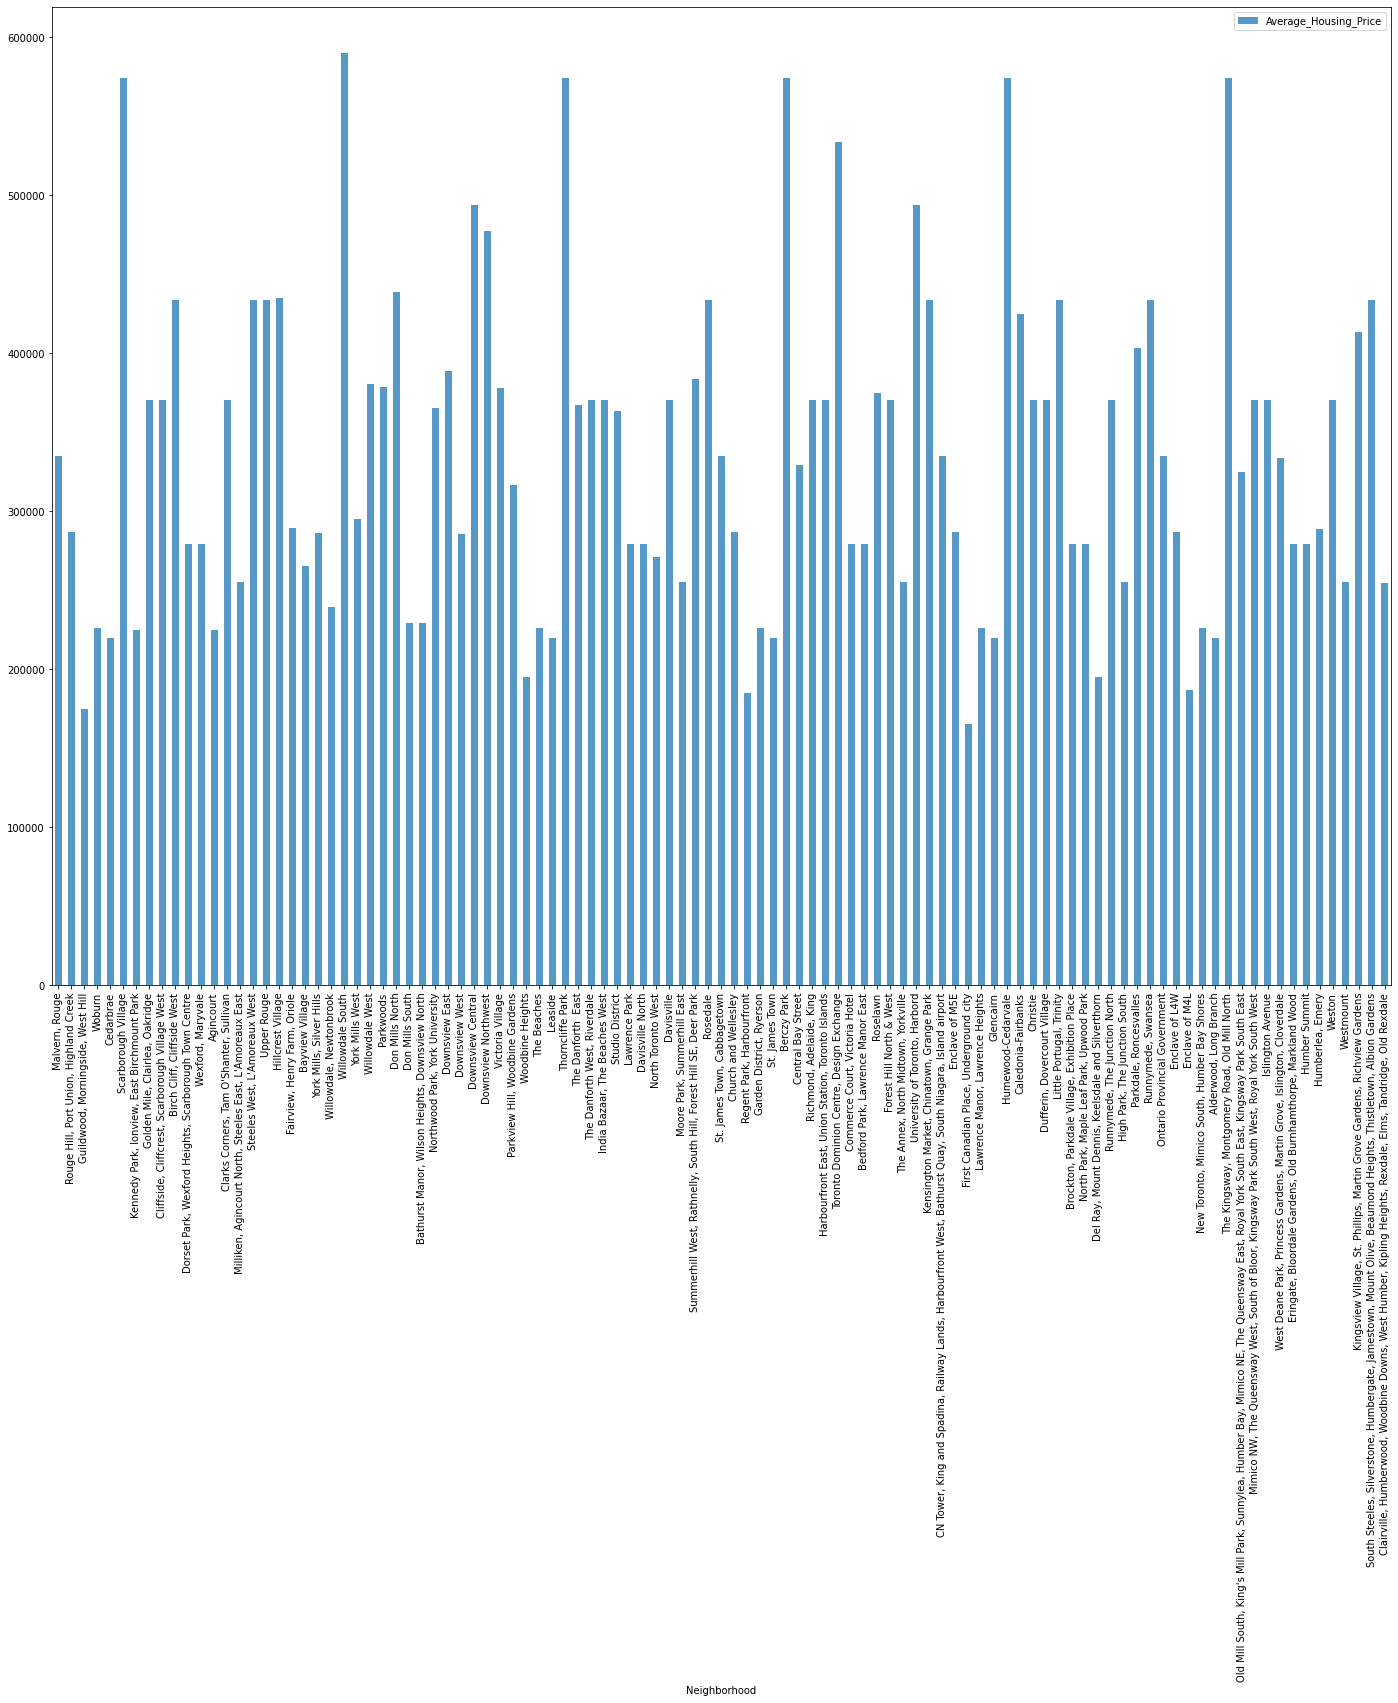

In [58]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

**School Rating according to clusters**

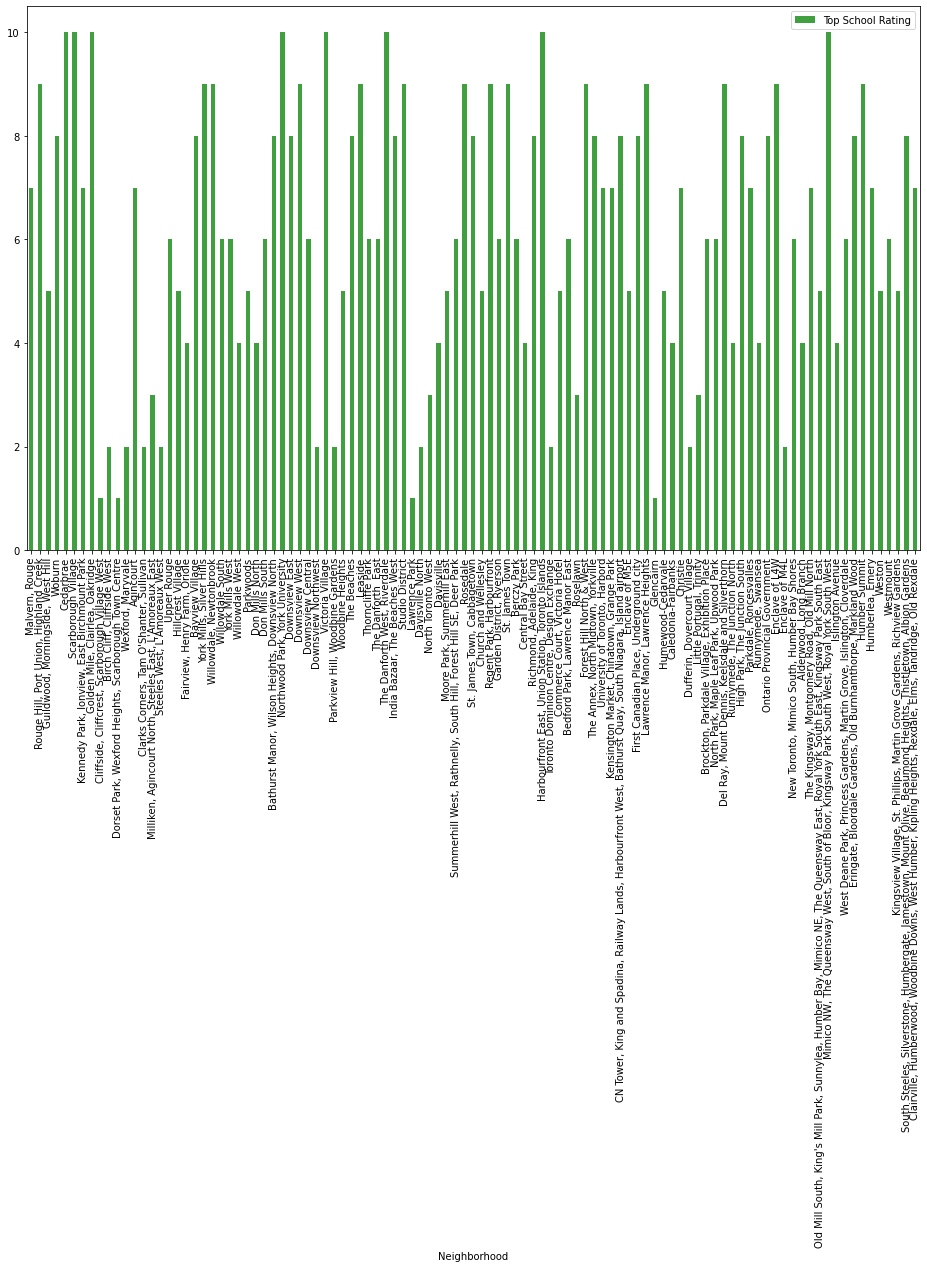

In [59]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75)